# Functions for Text Processing

* 4 CPU-intensive functions
  * f1: Decode base64 string
  * f2: Generate statistics
  * f3: Remove special characters
  * f4: Tokenize and count

In [1]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from tqdm import tqdm
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
import base64
import re

In [5]:
client = boto3.client('lambda')

In [6]:
function_prefix='TextProcessing'

In [7]:
function_count = 4
function_number = 4

In [8]:
# The difference between UTC and local timezone
timezone_offset = 0

## Create Functions for Constructing 4 Apps

### Function Name List

In [9]:
function_name_list = [function_prefix+'_f'+str(i) for i in range(1, function_count+1)]
print(function_name_list)

['TextProcessing_f1', 'TextProcessing_f2', 'TextProcessing_f3', 'TextProcessing_f4']


### Send Requests to Create Lambda Functions

In [ ]:
function_creation_response = []
for function in function_name_list:
    response = client.create_function(
        FunctionName=function,
        Runtime='python3.7',
        Role='arn:aws:iam::499537426559:role/ServerlessAppPerfOpt',
        Handler='lambda_function.lambda_handler',
        Code={
            'ZipFile': b"PK\x03\x04\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00lambda_function.pydef lambda_handler(event, context):\n    pass\n    return {\n        'statusCode': 200\n    }\nPK\x03\x04\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00.ipynb_checkpoints/PK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4\x81\x00\x00\x00\x00lambda_function.pyPK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\xfdA\x8a\x00\x00\x00.ipynb_checkpoints/PK\x05\x06\x00\x00\x00\x00\x02\x00\x02\x00\x81\x00\x00\x00\xbb\x00\x00\x00\x00\x00"
        },
        Description='Analytical Model Evaluation {}'.format(function),
        Timeout=60,
        MemorySize=128
    )
    function_creation_response.append(response)
    time.sleep(0.1)
print([item['StateReasonCode'] for item in function_creation_response])

## Update all Functions in TextProcessing App

### Update Function Code

In [ ]:
functions=[]
for file in os.listdir('functions'):
    path=os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/'+file))
    if not file.startswith('.') and os.path.isdir(path):
        functions.append(file)
for function_folder in functions:
    buf = BytesIO()
    with zipfile.ZipFile(buf, 'w') as z:
        for file in os.listdir('functions/'+function_folder):
            z.write(os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))), os.path.basename(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))))
    buf.seek(0)
    pkg = buf.read()
    client.update_function_code(FunctionName='{}_{}'.format(function_prefix, function_folder),ZipFile=pkg)

### Update Function Memory Configuration

In [10]:
mem_config_list={
    'f1':256,
    'f2':256,
    'f3':256,
    'f4':256
}

In [11]:
for function in mem_config_list.keys():
    client.update_function_configuration(FunctionName='{}_{}'.format(function_prefix, function), MemorySize=mem_config_list[function])

# Profile Functions

## Test Run

In [12]:
def f1(event):
    return {
        'statusCode': 200,
        'input': event['input'],
        'output': base64.b64decode(event['input']).decode('utf-8')
    }

f1_payload = {
      "input": base64.b64encode(str.encode("And like the baseless fabric of this vision, The cloud-capped towers, the gorgeous palaces, The solemn temples, the great globe itself— Yea, all which it inherit—shall dissolve, And like this insubstantial pageant faded, Leave not a rack behind. We are such stuff As dreams are made on, and our little life Is rounded with a sleep. Sir, I am vexed. Bear with my weakness. My old brain is troubled. Be not disturbed with my infirmity. If you be pleased, retire into my cell And there repose. A turn or two I’ll walk To still my beating mind."*200)).decode("utf-8")
}

In [13]:
def avg_word_length(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

def f2(event):
    input = event['output']
    stats = {}
    stats['text_length'] = len(input)
    stats['avg_word_length'] = avg_word_length(input)
    stats['num_digits'] = len([x for x in input.split() if x.isdigit()])
    stats['num_special_chars'] = len([x for x in input.split() if not x.isalnum()])
    return {
        'statusCode': 200,
        'stats': stats,
        'input': input
    }

f2_payload = f1(f1_payload)

In [14]:
def f3(event):
    input = event['input']
    cleaned_string = re.sub('\W+',' ', input)
    return {
        'statusCode': 200,
        'input': input,
        'output': cleaned_string
    }

f3_payload = f2(f2_payload)

In [15]:
f4_payload = f3(f3_payload)

In [16]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f1'), InvocationType='Event', Payload=json.dumps(f1_payload))

{'ResponseMetadata': {'RequestId': '5688d7dc-bdd8-46e9-8ed7-c13648621f27',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 29 Sep 2022 10:25:28 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5688d7dc-bdd8-46e9-8ed7-c13648621f27',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-63357298-2ab99de6143a56e511fdbe99;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f7b680a6f40>}

In [17]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f2'), InvocationType='Event', Payload=json.dumps(f2_payload))

{'ResponseMetadata': {'RequestId': 'fe86ed69-1516-43e3-beb1-4d35f0eeea65',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 29 Sep 2022 10:25:29 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fe86ed69-1516-43e3-beb1-4d35f0eeea65',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-63357299-64bb8f2759ca07ed2e320f46;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f7b680a6d30>}

In [18]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f3'), InvocationType='Event', Payload=json.dumps(f3_payload))

{'ResponseMetadata': {'RequestId': 'e12569bd-a302-40aa-a28b-667d2330c7f6',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 29 Sep 2022 10:25:31 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'e12569bd-a302-40aa-a28b-667d2330c7f6',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-6335729a-520bc7380b3c55ec40183d28;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f7ba8273f70>}

In [19]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f4'), InvocationType='Event', Payload=json.dumps(f4_payload))

{'ResponseMetadata': {'RequestId': '60215cff-0034-4fa7-909c-b485f8c46303',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 29 Sep 2022 10:25:32 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '60215cff-0034-4fa7-909c-b485f8c46303',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-6335729b-316a950161e8d5bd18bf0daa;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f7b67fa3370>}

In [20]:
logging.basicConfig(filename='invoke.log', encoding='utf-8', format='%(asctime)s.%(msecs)03d %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

## Run

In [21]:
payloads = {
    "TextProcessing_f1": f1_payload,
    "TextProcessing_f2": f2_payload,
    "TextProcessing_f3": f3_payload,
    "TextProcessing_f4": f4_payload
}

In [22]:
for i in range(0, 5000):
    time.sleep(2.4)
    for name in function_name_list:
        response = client.invoke(FunctionName=name, InvocationType='Event', Payload=json.dumps(payloads[name]))
        RequestId = response.get('ResponseMetadata', {}).get('RequestId')
        StatusCode = response.get('StatusCode', 'ERR')
        logging.info(f'{i+1} {StatusCode} {name} {RequestId}')
        time.sleep(0.1)

## Get the start time and the end time

In [23]:
profile_function_start_time = ' '.join(os.popen('head -1 invoke.log').read().split(' ')[:2])
profile_function_end_time = ' '.join(os.popen('tail -1 invoke.log').read().split(' ')[:2])
profile_function_start_time = datetime.strptime(profile_function_start_time, '%Y-%m-%d %H:%M:%S.%f')
profile_function_end_time = datetime.strptime(profile_function_end_time, '%Y-%m-%d %H:%M:%S.%f')

In [24]:
profile_function_start_time

datetime.datetime(2022, 9, 29, 10, 26, 31, 644000)

In [25]:
profile_function_end_time

datetime.datetime(2022, 9, 29, 17, 32, 44, 658000)

In [26]:
profile_function_start_time = int(datetime.timestamp(profile_function_start_time)) - 60

In [27]:
profile_function_end_time = int(datetime.timestamp(profile_function_end_time)) + 60

# CloudWatch Logs

In [28]:
logclient = boto3.client('logs')

## Query AppMdl Lambda Function Logs

### Functions for parsing Logs

In [29]:
def lambda_report_log_to_dict(log):
    res={}
    lis=[item.split(': ') for item in log[1]['value'].split('\t')]
    res['RequestId']=lis[0][1]
    res['Duration']=float(lis[1][1].split(' ')[0])
    res['Billed_Duration']=int(lis[2][1].split(' ')[0])
    res['Memory_Size']=int(lis[3][1].split(' ')[0])
    res['Max_Memory_Used']=int(lis[4][1].split(' ')[0])
    res['UTC_Timestamp'] = time.mktime(datetime.strptime(log[0]['value'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) +timezone_offset*3600
    return res

### Prepare Logs

In [30]:
query_lambda = []
for function in function_name_list:
    query_lambda.append(logclient.start_query(
        logGroupName='/aws/lambda/{}'.format(function),
        queryString="fields @timestamp, @message| filter @message like 'REPORT'| sort @timestamp asc",
        startTime=profile_function_start_time,
        endTime=profile_function_end_time,
        limit=10000
        ))
    time.sleep(4)
time.sleep(10)

### Retrieve Logs

In [31]:
query_lambda_results = []
for q in query_lambda:
    query_lambda_results.append(logclient.get_query_results(
        queryId=q['queryId']
    ))
    time.sleep(4)

In [32]:
with open('query_lambda_results.pickle', 'wb') as f:
    f.write(pickle.dumps(query_lambda_results))

In [33]:
AppMdl_lambda_logs_dict = {'f'+str(i):None for i in range(1, function_count+1)}
for i in range(1, function_count+1):
    AppMdl_lambda_logs_dict['f'+str(i)] = [lambda_report_log_to_dict(item) for item in query_lambda_results[i-1]['results']]
    for item in AppMdl_lambda_logs_dict['f'+str(i)]:
        item['Function']='f'+str(i)

In [34]:
len(AppMdl_lambda_logs_dict['f1'])

5000

#### Convert Logs into DataFrame and Save as CSV

In [88]:
AppMdl_lambda_logs=pd.DataFrame()
for i in range(1, function_count+1):
    AppMdl_lambda_logs = AppMdl_lambda_logs.append(pd.DataFrame(AppMdl_lambda_logs_dict['f'+str(i)]))
AppMdl_lambda_logs.index=range(AppMdl_lambda_logs.shape[0])
AppMdl_lambda_logs=AppMdl_lambda_logs[['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTC_Timestamp', 'RequestId']]
AppMdl_lambda_logs.to_csv('TextProcessing_lambda_logs.csv',index=False)

In [89]:
AppMdl_lambda_logs = pd.read_csv('TextProcessing_lambda_logs.csv', low_memory=False)
AppMdl_lambda_logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTCTimestamp', 'RequestId']

In [90]:
AppMdl_lambda_logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,UTCTimestamp,RequestId
0,f1,256,40,5.40,6,1.664447e+09,b025208d-f56c-476c-8e4c-73f8c916913b
1,f1,256,40,4.68,5,1.664447e+09,f663dbbd-b8ab-4c6b-940e-783fa24157e0
2,f1,256,40,18.91,19,1.664447e+09,428dc6de-44f2-40be-a869-3c19d07025e5
3,f1,256,40,4.51,5,1.664447e+09,d257e73a-5e8d-4919-add6-dbb8c9640c14
4,f1,256,40,4.22,5,1.664447e+09,2c2fd8e4-14f4-4916-99f5-c9743aff1265


In [38]:
for i in range(1, function_count+1):
    print(f"f{i}", AppMdl_lambda_logs.query(f"Function == 'f{i}'").shape[0], AppMdl_lambda_logs.query(f"Function == 'f{i}'")['Duration'].mean())

f1 5000 8.414878
f2 5000 74.255486
f3 5001 55.49091181763648
f4 5001 75.90968206358728


In [39]:
def calculate_cost(rt: float, mem: float, pmms: float = 1.627607421875e-11, ppi: float = 0.0000002) -> float:
    return math.ceil(rt) * mem * pmms + ppi

## Plot Performance Profile Graphs

In [41]:
f1_duration = AppMdl_lambda_logs.query("Function == 'f1'")['Duration'].to_list()
f1_cost = [calculate_cost(duration, mem_config_list['f1'] * 1000000) for duration in f1_duration]
f2_duration = AppMdl_lambda_logs.query("Function == 'f2'")['Duration'].to_list()
f2_cost = [calculate_cost(duration, mem_config_list['f2'] * 1000000) for duration in f2_duration]
f3_duration = AppMdl_lambda_logs.query("Function == 'f3'")['Duration'].to_list()
f3_cost = [calculate_cost(duration, mem_config_list['f3'] * 1000000) for duration in f3_duration]
f4_duration = AppMdl_lambda_logs.query("Function == 'f4'")['Duration'].to_list()
f4_cost = [calculate_cost(duration, mem_config_list['f4'] * 1000000) for duration in f4_duration]

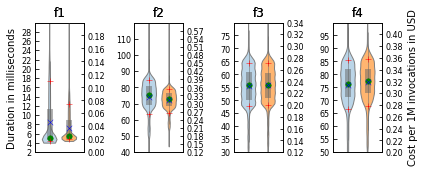

In [87]:
df_f1 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f1"]
df_f2 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f2"]
df_f3 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f3"]
df_f4 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f4"]
sampleNum = min(len(df_f1), len(df_f2), len(df_f3), len(df_f4))
dur_f1 = np.asarray(df_f1[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f2 = np.asarray(df_f2[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f3 = np.asarray(df_f3[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f4 = np.asarray(df_f4[:sampleNum].Duration.values).reshape(sampleNum, 1)
# concat data for plotting
# durations = np.concatenate((dur_f1, dur_f2, dur_f3, dur_f4),axis=1)
# plot:
fig, (ax_f1, ax_f2, ax_f3, ax_f4) = plt.subplots(nrows=1, ncols=4, figsize=(6, 2.4))

# plot f1
vp1 = ax_f1.violinplot(f1_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f1.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(2, 30), yticks=np.arange(2, 30, 2),
       title="f1")
ax_f1_cost = ax_f1.twinx()
vp1_twin = ax_f1_cost.violinplot(
        f1_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f1_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(0, 0.2), yticks=np.arange(0, 0.2, 0.02),
       title="f1")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f1_duration, [10, 25, 50, 75, 90])
mean = np.mean(f1_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f1_duration), quartile25, quartile75)
ax_f1.scatter([1.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f1.scatter([1.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f1.scatter([1.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f1.scatter([1.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f1.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f1.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f1_cost, [10, 25, 50, 75, 90])
mean = np.mean(f1_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f1_cost), quartile25, quartile75)
ax_f1_cost.scatter([3.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f1_cost.scatter([3.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f1_cost.scatter([3.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f1_cost.scatter([3.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f1_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f1_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f1.tick_params(axis='both', which='major', labelsize=8)
ax_f1_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f1.set_xticklabels([])
ax_f1_cost.set_xticklabels([])
ax_f1.tick_params(direction='in', bottom=False)
ax_f1_cost.tick_params(direction='in', bottom=False)



# plot f2
vp1 = ax_f2.violinplot(f2_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f2.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(40, 120), yticks=np.arange(40, 120, 10),
       title="f2")
ax_f2_cost = ax_f2.twinx()
vp1_twin = ax_f2_cost.violinplot(
        f2_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f2_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(0.12, 0.6), yticks=np.arange(0.12, 0.6, 0.03),
       title="f2")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f2_duration, [10, 25, 50, 75, 90])
mean = np.mean(f2_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f2_duration), quartile25, quartile75)
ax_f2.scatter([1.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f2.scatter([1.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f2.scatter([1.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f2.scatter([1.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f2.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f2.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f2_cost, [10, 25, 50, 75, 90])
mean = np.mean(f2_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f2_cost), quartile25, quartile75)
ax_f2_cost.scatter([3.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f2_cost.scatter([3.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f2_cost.scatter([3.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f2_cost.scatter([3.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f2_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f2_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f2.tick_params(axis='both', which='major', labelsize=8)
ax_f2_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f2.set_xticklabels([])
ax_f2_cost.set_xticklabels([])
ax_f2.tick_params(direction='in', bottom=False)
ax_f2_cost.tick_params(direction='in', bottom=False)


# plot f3
vp1 = ax_f3.violinplot(f3_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f3.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(30, 80), yticks=np.arange(30, 80, 5),
       title="f3")
ax_f3_cost = ax_f3.twinx()
vp1_twin = ax_f3_cost.violinplot(
        f3_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f3_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(0.12, 0.34), yticks=np.arange(0.12, 0.34, 0.02),
       title="f3")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f3_duration, [10, 25, 50, 75, 90])
mean = np.mean(f3_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f3_duration), quartile25, quartile75)
ax_f3.scatter([1.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f3.scatter([1.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f3.scatter([1.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f3.scatter([1.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f3.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f3.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f3_cost, [10, 25, 50, 75, 90])
mean = np.mean(f3_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f3_cost), quartile25, quartile75)
ax_f3_cost.scatter([3.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f3_cost.scatter([3.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f3_cost.scatter([3.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f3_cost.scatter([3.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f3_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f3_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f3.tick_params(axis='both', which='major', labelsize=8)
ax_f3_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f3.set_xticklabels([])
ax_f3_cost.set_xticklabels([])
ax_f3.tick_params(direction='in', bottom=False)
ax_f3_cost.tick_params(direction='in', bottom=False)

# plot f4
vp1 = ax_f4.violinplot(f4_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f4.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(50, 100), yticks=np.arange(50, 100, 5),
       title="f4")
ax_f4_cost = ax_f4.twinx()
vp1_twin = ax_f4_cost.violinplot(
        f4_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f4_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(0.2, 0.42), yticks=np.arange(0.2, 0.42, 0.02),
       title="f4")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f4_duration, [10, 25, 50, 75, 90])
mean = np.mean(f4_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f4_duration), quartile25, quartile75)
ax_f4.scatter([1.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f4.scatter([1.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f4.scatter([1.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f4.scatter([1.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f4.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f4.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f4_cost, [10, 25, 50, 75, 90])
mean = np.mean(f4_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f4_cost), quartile25, quartile75)
ax_f4_cost.scatter([3.5], medians, marker='o', color='green', s=30, zorder=3, linewidths=0.5)
ax_f4_cost.scatter([3.5], mean, marker='x', color='blue', s=30, zorder=3, linewidths=0.5)
ax_f4_cost.scatter([3.5], percentile10, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f4_cost.scatter([3.5], percentile90, marker='+', color='red', s=30, zorder=3, linewidths=0.5)
ax_f4_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f4_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f4.tick_params(axis='both', which='major', labelsize=8)
ax_f4_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f4.set_xticklabels([])
ax_f4_cost.set_xticklabels([])
ax_f4.tick_params(direction='in', bottom=False)
ax_f4_cost.tick_params(direction='in', bottom=False)


ax_f1.set_ylabel('Duration in milliseconds')
ax_f4_cost.set_ylabel('Cost per 1M invocations in USD')


plt.subplots_adjust(bottom=0.15, wspace=0.3)
plt.tight_layout()
plt.show()
fig.savefig("4_function_pp.pdf")